# nd 原版

In [100]:
import numpy as np
import random
tao_points = np.array([
    0, 0.045, 0.105, 0.209, 0.292, 0.396, 0.5, 0.604, 0.708, 0.794, 0.9, 1
])
x_points = np.array([
    0, 10.329, 22.755, 38.104, 55.757, 58.086, 66.722, 78.909, 106.655, 124.542, 124.553, 126.646
])

def get_x_from_tau(tau, detail_output=False):
    if tau <= tao_points[0]:
        return x_points[0]
    int_part = np.floor(tau)
    x_val = int_part * x_points[-1]
    tau = tau - int_part

    idx = np.searchsorted(tao_points, tau, side='right') - 1

    tau_start = tao_points[idx]
    tau_end = tao_points[idx + 1]
    x_start = x_points[idx]
    x_end = x_points[idx + 1]

    current_slope = (x_end - x_start) / (tau_end - tau_start)

    x_val += x_start + current_slope * (tau - tau_start)

    return x_val


# Segment lengths
segments = [225+601, 462+467]
# T range
T_min = 715
T_max = 1149
num_simulations = 1000000
count_S_greater_than_TH = 0
S_values = []
for i in range(num_simulations):
    current_S = 0
    for j, segment_length in enumerate(segments):
        T = random.randint(T_min, T_max)

        tau = segment_length / T
        X = get_x_from_tau(tau)
        current_S += X

    S_values.append(current_S)
    TH = random.uniform(335, 344) #6炮对于最左巨人行走335，对于最右巨人344

    if current_S > TH:
        count_S_greater_than_TH += 1


# 统计结果
percent = count_S_greater_than_TH / num_simulations * 100

print(count_S_greater_than_TH)
print(f'{percent:.3f}%')

198
0.020%


# nd 改版

In [101]:
import numpy as np

tao_points = np.array([
    0, 0.045, 0.105, 0.209, 0.292, 0.396, 0.5, 0.604, 0.708, 0.794, 0.9, 1
])
x_points = np.array([
    0, 10.329, 22.755, 38.104, 55.757, 58.086, 66.722, 78.909, 106.655, 124.542, 124.553, 126.646
])

def get_x_from_tau_vec(tau):
    # tau: shape (n,) or (n, m)
    tau = np.asarray(tau)
    int_part = np.floor(tau)
    x_val = int_part * x_points[-1]
    tau_mod = tau - int_part

    # 处理 tau_mod <= tao_points[0] 的情况
    idx = np.searchsorted(tao_points, tau_mod, side='right') - 1
    idx = np.clip(idx, 0, len(tao_points) - 2)  # 防止越界

    tau_start = tao_points[idx]
    tau_end = tao_points[idx + 1]
    x_start = x_points[idx]
    x_end = x_points[idx + 1]
    current_slope = (x_end - x_start) / (tau_end - tau_start)
    x_val += np.where(
        tau_mod <= tao_points[0],
        x_points[0],
        x_start + current_slope * (tau_mod - tau_start)
    )
    return x_val

# 向量化模拟
num_simulations = 100000000
segments = np.array([225+601, 462+467])

# 随机速度
v = np.random.uniform(0.23, 0.37, size=(num_simulations, 2))
T = np.ceil(124.1 / 0.47 / v)
tau = segments / T  # shape: (num_simulations, 2)

# 计算每段的X
X = get_x_from_tau_vec(tau)  # shape: (num_simulations, 2)
current_S = X.sum(axis=1)    # shape: (num_simulations,)

# 随机阈值
TH = np.random.randint(334, 344, size=num_simulations)

# 统计结果
count_S_greater_than_TH = np.sum(current_S > TH)
percent = count_S_greater_than_TH / num_simulations * 100

print(count_S_greater_than_TH)
print(f'{percent:.3f}%')

101687
0.102%


# 新版

In [102]:
import numpy as np

frame_x = np.array([
    4.5,4.5,4.5,4.4,4.5,
    2.9,3,3,2.9,3,
    4.4,4.4,4.4,4.4,
    0.4,0.5,0.4,0.5,0.4,
    1.7,1.7,1.7,1.7,1.7,
    2.4,2.4,2.4,2.4,2.4,
    5.3,5.4,5.4,5.4,5.4,
    4.5,4.4,4.5,4.5,
    0,0,0,0,0,
    0.4,0.4,0.2,0.4,0.4,
])
frame_piece_n = np.array([
    5, 5, 4, 5, 5, 5, 5, 4, 5, 5
])
frame_point_n = np.concatenate(([0], frame_piece_n.cumsum()))
frame_piece_x = np.array([
    frame_x[frame_point_n[i]:frame_point_n[i+1]].sum() 
    for i in range(len(frame_piece_n))
])
frame_piece_cum_x = np.concatenate(([0], frame_piece_x.cumsum()))
N = frame_piece_n.sum()
s = frame_piece_x.sum()

def calc_x(t, v, detail_output=False):
    frame = N*0.47/s*v*t
    frame_int = np.floor(frame / N)
    frame_mod = frame % N
    piece_idx = np.searchsorted(frame_point_n, frame_mod, side='right') - 1
    frame_mod_mod = frame_mod - frame_point_n[piece_idx]
    ans = (
        s * frame_int 
        + frame_piece_cum_x[piece_idx]
        + frame_piece_x[piece_idx] * frame_mod_mod / frame_piece_n[piece_idx]
    )
    if detail_output:
        print(f'frame: {frame}, frame_int: {frame_int}, frame_mod: {frame_mod}, frame_mod_mod: {frame_mod_mod}')
        print(f'piece_idx: {piece_idx}, piece_n: {frame_piece_n[piece_idx]}, piece_x: {frame_piece_x[piece_idx]}')
        print(f's_int: {s * frame_int}, s_cum: {frame_piece_cum_x[piece_idx]}, s_piece: {frame_piece_x[piece_idx] * frame_mod_mod / frame_piece_n[piece_idx]}')
    return ans * (N+1) / N


# 向量化模拟
num_simulations = 100000
segments = np.array([225+601, 462+467])

# 随机速度
v = np.random.uniform(0.23, 0.37, size=(num_simulations, 2))
t = segments[np.newaxis, :] * np.ones((num_simulations, 2))  # shape (num_simulations, 2)

# 计算每段的X
X = calc_x(t, v)  # shape: (num_simulations, 2)
current_S = X.sum(axis=1)    # shape: (num_simulations,)

# 随机阈值
TH = np.random.randint(334, 344, size=num_simulations)

# 统计结果
count_S_greater_than_TH = np.sum(current_S > TH)
percent = count_S_greater_than_TH / num_simulations * 100

print(count_S_greater_than_TH)
print(f'{percent:.3f}%')

130
0.130%


In [103]:
import pandas as pd
import matplotlib.pyplot as plt

In [136]:
t_dlt = 1
t_arr = np.arange(0, 1500, t_dlt)
x_arr = calc_x(t_arr, 0.37)
v_arr = np.diff(x_arr)
v_arr_diff = np.abs(np.diff(v_arr))
shift_idx = np.where(v_arr_diff > 0.005)[0]
shift_t = t_arr[shift_idx]
shift_t = shift_t[np.r_[np.diff(shift_t) != t_dlt, True]]
print(shift_t)

[  74  148  208  282  356  431  505  564  639  713  787  862  921  996
 1070 1144 1219 1278 1352 1427]


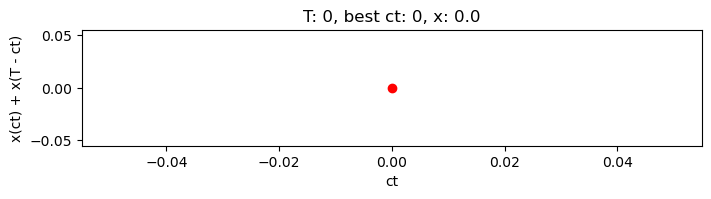

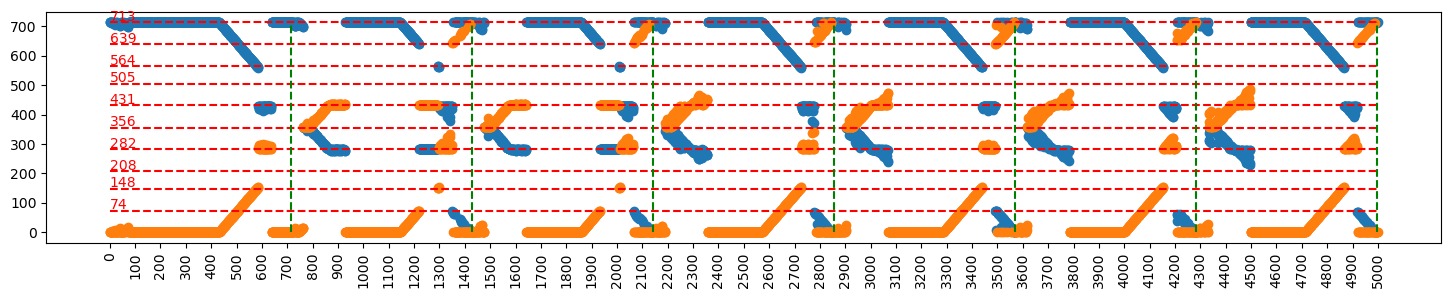

In [178]:
T_sup = 5000
T_arr = np.arange(0, T_sup, t_dlt)
v = 0.37
T_cyc = 1 / 0.47 * s / v

ans_best_ct = []
for T in T_arr:
    ct_arr = np.arange(0, T // 2 + 1, t_dlt)
    cx_arr = calc_x(ct_arr, v) + calc_x(T - ct_arr, v)

    best_ct = np.argmin(cx_arr)
    ans_best_ct.append(best_ct)
    if T % 50000 == 0:
        plt.figure(figsize=(8, 1.5))
        plt.plot(ct_arr, cx_arr)
        plt.plot(best_ct, cx_arr[best_ct], 'ro')
        plt.title(f'T: {T}, best ct: {best_ct}, x: {cx_arr[best_ct]}')
        plt.xlabel('ct')
        plt.ylabel('x(ct) + x(T - ct)')
        plt.show()

ans_best_ct %= T_cyc

plt.figure(figsize=(18, 3))
plt.scatter(T_arr, T_cyc - ans_best_ct)
plt.scatter(T_arr, ans_best_ct)

# plt.plot([0, T_sup], [0, T_sup], 'k--')
for y in shift_t[shift_t <= T_cyc]:
    plt.hlines(y=y, xmin=0, xmax=T_sup, colors='r', linestyles='dashed')
    plt.text(x=T_sup*0.0, y=y+5, s=f'{y}', color='r')
for i in range(1, int(T_sup // T_cyc) + 1):
    plt.vlines(x=i*T_cyc, ymin=0, ymax=T_cyc, colors='g', linestyles='dashed')
plt.xticks(np.arange(0, T_sup+1, 100), rotation=90)
plt.show()

In [148]:
cts = [714, 0]
T = 1000
for ct in cts:
    print(f'ct: {ct}, x: {calc_x(ct, 0.37) + calc_x(T - ct, 0.37)}')

ct: 714, x: 185.39830630136981
ct: 0, x: 185.32739726027395


In [129]:
std = pd.read_csv('../output.csv')['value'].values
sim = std[0] - calc_x(np.arange(0, len(std), 1), 0.37)

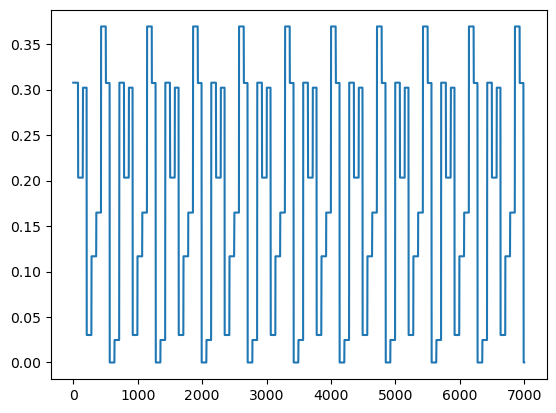

In [130]:
plt.plot(- np.diff(sim))

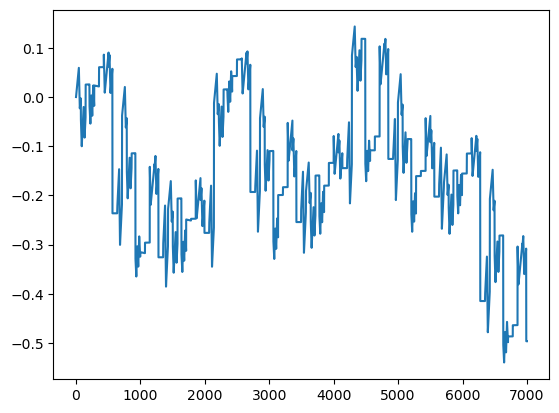

In [131]:
plt.plot(sim - std)

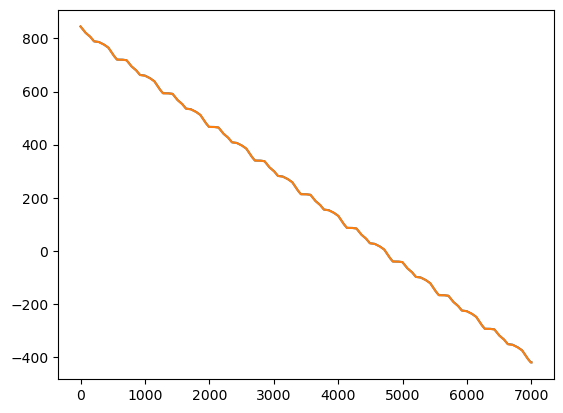

In [132]:
plt.plot(std, label='Standard')
plt.plot(sim, label='Simulation')